In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q transformers biopython kaggle
print("✅ Đã cài đặt xong thư viện!")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 110.0 MB/s eta 0:00:00
✅ Đã cài đặt xong thư viện!


In [2]:
import os
from google.colab import files

# Upload file kaggle.json
print("Vui lòng upload file kaggle.json của bạn:")
files.upload()

# Cấu hình Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Tải dữ liệu cuộc thi (Sẽ mất khoảng 1-2 phút)
print("⏳ Đang tải dữ liệu CAFA 6...")
!kaggle competitions download -c cafa-6-protein-function-prediction
!unzip -q cafa-6-protein-function-prediction.zip -d /content/cafa6_data
print("✅ Đã tải và giải nén dữ liệu tại /content/cafa6_data")

Vui lòng upload file kaggle.json của bạn:


Saving kaggle.json to kaggle.json
⏳ Đang tải dữ liệu CAFA 6...
  0% 0.00/91.2M [00:00<?, ?B/s]
100% 91.2M/91.2M [00:00<00:00, 1.81GB/s]
✅ Đã tải và giải nén dữ liệu tại /content/cafa6_data


In [3]:
!kaggle datasets download -d seddiktrk/cafa6-protein-embeddings-esm2

# 3. Giải nén vào thư mục tên là 'esm2_data'
!unzip -q cafa6-protein-embeddings-esm2.zip -d /content/esm2_data

print("✅ Đã tải và giải nén xong vào folder: /content/esm2_data")

Dataset URL: https://www.kaggle.com/datasets/seddiktrk/cafa6-protein-embeddings-esm2
License(s): apache-2.0
 91% 1.16G/1.27G [00:07<00:02, 42.7MB/s]
100% 1.27G/1.27G [00:07<00:00, 192MB/s] 
✅ Đã tải và giải nén xong vào folder: /content/esm2_data


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm.auto import tqdm
import gc
import os
import sys

# ============================================================================
# CONFIG CHO ANKH-BASE
# ============================================================================
CONFIG = {
    # Đường dẫn dữ liệu (Nơi bạn đã gộp file FINAL)
    'EMBED_DIR': '/content/esm2_data',
    'SAVE_DIR': '/content/drive/MyDrive/CAFA6_Results/ESM2_Run',
    'TRAIN_TERMS': '/content/cafa6_data/Train/train_terms.tsv',
    'TEST_FASTA': '/content/cafa6_data/Test/testsuperset.fasta',

    # Model Params
    'TOP_K_LABELS': 15000,

    # Kiến trúc mạng: Điều chỉnh cho Ankh-Base (Input 768)
    # Giảm xuống [1024, 512, 256] là đủ mạnh và train nhanh
    'HIDDEN_DIMS': [1024, 512, 256],

    'DROPOUT_RATE': 0.25,         # Dropout chuẩn
    'EPOCHS': 40,
    'BATCH_SIZE': 128,            # Tăng batch size lên được nếu RAM dư
    'LEARNING_RATE': 1e-3,        # Tăng LR lên lại 1e-3 vì mạng nhỏ hơn dễ học hơn
    'LABEL_SMOOTHING': 0.1,

    # Inference Params
    'TEMPERATURE': 1.0,
    'MIN_CONFIDENCE': 0.01,
    'MAX_PREDS_PER_PROTEIN': 20,

    'SEED': 42,
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Tạo thư mục lưu kết quả
os.makedirs(CONFIG['SAVE_DIR'], exist_ok=True)

print("="*80)
print(f"🚀 CAFA 6 - ANKH-BASE TRAINING | Device: {CONFIG['DEVICE']}")
print("="*80)

# Set seed
torch.manual_seed(CONFIG['SEED'])
np.random.seed(CONFIG['SEED'])

# ============================================================================
# 1. LOAD DATA (ANKH BASE)
# ============================================================================
# Cần thêm thư viện BioPython để đọc file Fasta lấy Test ID
try:
    from Bio import SeqIO
except ImportError:
    print("⚠️ Đang cài đặt Biopython...")
    os.system('pip install biopython')
    from Bio import SeqIO

# ============================================================================
# 1. LOAD DATA (ESM2 LOGIC)
# ============================================================================
print("\n[1/5] Loading ESM2 Data & Splitting...")

# 1. Load File Embeddings Gốc (Chứa cả Train và Test)
print("   ⏳ Loading big embedding file...")
all_embeddings = np.load(f"{CONFIG['EMBED_DIR']}/protein_embeddings.npy") # Shape (N, 1280)
all_ids_df = pd.read_csv(f"{CONFIG['EMBED_DIR']}/protein_ids.csv")
all_ids = all_ids_df["protein_id"].tolist()

print(f"   ✓ Loaded Total Embeddings: {all_embeddings.shape}")

# 2. Xác định Train IDs (Từ file train_terms.tsv)
print("   ⏳ Identifying Train IDs...")
df_terms_temp = pd.read_csv(CONFIG['TRAIN_TERMS'], sep='\t')
target_train_ids = df_terms_temp["EntryID"].unique().tolist()
del df_terms_temp # Xóa ngay để tiết kiệm RAM

# 3. Xác định Test IDs (Từ file fasta)
print("   ⏳ Identifying Test IDs...")
target_test_ids = []
# Đọc file fasta để lấy ID chuẩn của tập test
for record in SeqIO.parse(CONFIG['TEST_FASTA'], "fasta"):
    # Lấy phần đầu của ID (ví dụ 'P12345' từ 'P12345 additional info')
    pid = record.id.split()[0]
    target_test_ids.append(pid)

# 4. Tạo Map: ID -> Index trong file embedding lớn
print("   ⏳ Mapping IDs to Indices...")
id_to_index = {pid: i for i, pid in enumerate(all_ids)}

# 5. Lọc lấy Index cho Train và Test
# Chỉ lấy những ID nào CÓ tồn tại trong file embedding ESM2
train_idx = [id_to_index[i] for i in target_train_ids if i in id_to_index]
test_idx  = [id_to_index[i] for i in target_test_ids  if i in id_to_index]

# 6. Tách dữ liệu ra thành biến riêng (để khớp với phần code phía sau của bạn)
X_train_embeds = all_embeddings[train_idx]
# Lấy lại danh sách ID train thực tế tìm thấy (để map với labels sau này)
train_ids = [all_ids[i] for i in train_idx]
# Chuyển thành numpy array cho đồng bộ code cũ
train_ids = np.array(train_ids)

X_test_embeds = all_embeddings[test_idx]
test_ids = [all_ids[i] for i in test_idx]
test_ids = np.array(test_ids)

print(f"   ✓ Final Train Shape: {X_train_embeds.shape}")
print(f"   ✓ Final Test Shape:  {X_test_embeds.shape}")

if X_train_embeds.shape[1] != 1280:
    print(f"   ⚠️ Cảnh báo: Input dimension là {X_train_embeds.shape[1]}, hãy chỉnh lại CONFIG['HIDDEN_DIMS']!")

# 7. Dọn dẹp RAM (Quan trọng vì file ESM2 rất nặng)
del all_embeddings, all_ids_df, all_ids, id_to_index
gc.collect()

print("\nProcessing Labels with IA Strategy...")

# 1. Load Train Terms
print("   ⏳ Reading train terms...")
df_terms = pd.read_csv(CONFIG['TRAIN_TERMS'], sep='\t', header=0, names=['EntryID', 'term', 'aspect'])

# 2. Load IA File
print("   ⏳ Reading IA weights...")
# File IA không có header, cột 1 là Term, cột 2 là IA Value
df_ia = pd.read_csv('/content/cafa6_data/IA.tsv', sep='\t', names=['term', 'ia'])
ia_dict = dict(zip(df_ia['term'], df_ia['ia']))

# 3. Tính toán Selection Score
# Bước này rất quan trọng: kết hợp độ phổ biến (Freq) và độ quan trọng (IA)
term_counts = df_terms['term'].value_counts().reset_index()
term_counts.columns = ['term', 'freq']

# Map IA vào bảng count. Nếu không tìm thấy IA (hiếm), gán mặc định = 0
term_counts['ia'] = term_counts['term'].map(ia_dict).fillna(0.0)

# Tính Score = Freq * IA
# Root terms (IA=0) -> Score=0 (Loại)
# Rare terms (Freq thấp) -> Score thấp (Loại)
# Các term tốt (Freq ổn + IA cao) -> Score cao (Giữ lại)
term_counts['score'] = term_counts['freq'] * term_counts['ia']

# 4. Chọn Top K
top_terms_df = term_counts.sort_values(by='score', ascending=False).head(CONFIG['TOP_K_LABELS'])
top_terms = top_terms_df['term'].tolist()

print(f"   ✓ Selected {len(top_terms)} terms based on Freq*IA.")
print(f"     -> Max Score: {top_terms_df['score'].max():.2f} | Min Score: {top_terms_df['score'].min():.2f}")

# Lọc dataframe ban đầu để tiết kiệm bộ nhớ
df_filtered = df_terms[df_terms['term'].isin(top_terms)]
id_to_terms = df_filtered.groupby('EntryID')['term'].apply(list).to_dict()

# ============================================================================
# 3. PREPARE DATA & CLASS WEIGHTS (RAM OPTIMIZED)
# ============================================================================
print("\n[3/5] Preparing Tensors & Weights (Optimized)...")

# 1. MultiLabelBinarizer - QUAN TRỌNG: sparse_output=True
# Để tránh tạo ma trận dày đặc ngay lập tức
mlb = MultiLabelBinarizer(classes=top_terms, sparse_output=True)
mlb.fit([top_terms])

# 2. Transform y_train (Ra ma trận thưa CSR)
print("   ⏳ Transforming labels to sparse matrix...")
y_labels_list = [id_to_terms.get(pid, []) for pid in train_ids]
y_train_sparse = mlb.transform(y_labels_list)

# 3. Tạo Tensor Weights (IA)
# (Vẫn giữ logic IA của bạn, nhưng cái này nhẹ nên không sao)
weights_list = [ia_dict.get(t, 0.0) for t in mlb.classes_]
pos_weight_tensor = torch.tensor(weights_list, dtype=torch.float32).to(CONFIG['DEVICE'])

print(f"   ✓ Created pos_weight tensor shape: {pos_weight_tensor.shape}")

# 4. Convert sang Dense nhưng ép kiểu float32 NGAY LẬP TỨC
# Lưu ý: Label Smoothing làm mất tính thưa (biến số 0 thành 0.0001),
# nên ta sẽ thực hiện smoothing TRỰC TIẾP TRÊN TENSOR để tiết kiệm RAM copy
print("   ⏳ Converting to Dense Float32...")
y_train_binary = y_train_sparse.astype(np.float32).toarray()

# Xóa ngay biến rác
del y_train_sparse, y_labels_list
gc.collect()

# 5. Label Smoothing & Convert to Tensor
# Dùng torch.from_numpy để KHÔNG COPY dữ liệu (Share memory)
y_train_tensor = torch.from_numpy(y_train_binary)

# Thực hiện Label Smoothing trực tiếp trên Tensor (In-place operation)
if CONFIG['LABEL_SMOOTHING'] > 0:
    print("   ⏳ Applying Label Smoothing...")
    # Công thức: y = y * (1-e) + e/K
    # Làm thế này đỡ tốn RAM hơn nhân numpy
    y_train_tensor = y_train_tensor * (1 - CONFIG['LABEL_SMOOTHING']) + (CONFIG['LABEL_SMOOTHING'] / len(top_terms))

# Xóa bản numpy vì giờ đã có tensor (hoặc giữ lại nếu RAM dư, nhưng tốt nhất là xóa)
del y_train_binary
gc.collect()

# Convert X to Tensor (Dùng from_numpy)
X_train_tensor = torch.from_numpy(X_train_embeds).float()

print(f"   ✓ Tensors Ready: X={X_train_tensor.shape}, y={y_train_tensor.shape}")

# 6. Data Split (Giữ nguyên)
# Lưu ý: train_test_split của sklearn sẽ copy dữ liệu, có thể gây tràn RAM lần nữa.
# Chúng ta sẽ dùng Indices split để an toàn hơn.
print("   ⏳ Splitting Train/Val...")
indices = np.arange(len(X_train_tensor))
train_idx, val_idx = train_test_split(indices, test_size=0.15, random_state=CONFIG['SEED'])

# Tạo Subset (Không copy dữ liệu gốc, chỉ tham chiếu)
train_dataset = TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
val_dataset = TensorDataset(X_train_tensor[val_idx], y_train_tensor[val_idx])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False)

# Dọn dẹp cuối cùng
del df_terms, df_filtered, id_to_terms, df_ia, term_counts
gc.collect()

# ============================================================================
# 2. MODEL ARCHITECTURE
# ============================================================================
print("\n[2/5] Building MLP Model...")

class AnkhMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, dropout):
        super().__init__()
        layers = []
        prev_dim = input_dim

        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.BatchNorm1d(dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = dim

        self.encoder = nn.Sequential(*layers)
        self.output = nn.Linear(prev_dim, output_dim)

    def forward(self, x):
        return self.output(self.encoder(x))

model = AnkhMLP(
    input_dim=X_train_tensor.shape[1],
    output_dim=CONFIG['TOP_K_LABELS'],
    hidden_dims=CONFIG['HIDDEN_DIMS'],
    dropout=CONFIG['DROPOUT_RATE']
).to(CONFIG['DEVICE'])

# ============================================================================
# 3. TRAINING
# ============================================================================
print("\n" + "="*80)
print(f"TRAINING START ({CONFIG['EPOCHS']} Epochs)")
print("="*80)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['LEARNING_RATE'], weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

best_val_loss = float('inf')
best_model_path = f"{CONFIG['SAVE_DIR']}/ankh_base_best.pth"

for epoch in range(CONFIG['EPOCHS']):
    # Train
    model.train()
    train_loss = 0
    for X_b, y_b in train_loader:
        X_b, y_b = X_b.to(CONFIG['DEVICE']), y_b.to(CONFIG['DEVICE'])

        optimizer.zero_grad()
        logits = model(X_b)
        loss = criterion(logits, y_b)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    avg_train = train_loss / len(train_loader)

    # Val
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_b, y_b in val_loader:
            X_b, y_b = X_b.to(CONFIG['DEVICE']), y_b.to(CONFIG['DEVICE'])
            logits = model(X_b)
            loss = criterion(logits, y_b)
            val_loss += loss.item()

    avg_val = val_loss / len(val_loader)

    scheduler.step(avg_val)
    curr_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1:02d} | Train: {avg_train:.4f} | Val: {avg_val:.4f} | LR: {curr_lr:.1e}")

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), best_model_path)
        print("  ⭐ New Best Model!")

print(f"\n✅ Training Done! Best Loss: {best_val_loss:.4f}")

# ============================================================================
# 4. PREDICTION & SUBMISSION
# ============================================================================
print("\n[4/5] Predicting & Creating Submission...")

del optimizer, scheduler, criterion, train_loader, val_loader
gc.collect()
torch.cuda.empty_cache()

🚀 CAFA 6 - ANKH-BASE TRAINING | Device: cuda

[1/5] Loading ESM2 Data & Splitting...
   ⏳ Loading big embedding file...
   ✓ Loaded Total Embeddings: (287001, 1280)
   ⏳ Identifying Train IDs...
   ⏳ Identifying Test IDs...
   ⏳ Mapping IDs to Indices...
   ✓ Final Train Shape: (82404, 1280)
   ✓ Final Test Shape:  (224309, 1280)

Processing Labels with IA Strategy...
   ⏳ Reading train terms...
   ⏳ Reading IA weights...
   ✓ Selected 15000 terms based on Freq*IA.
     -> Max Score: 18596.92 | Min Score: 2.66

[3/5] Preparing Tensors & Weights (Optimized)...
   ⏳ Transforming labels to sparse matrix...
   ✓ Created pos_weight tensor shape: torch.Size([15000])
   ⏳ Converting to Dense Float32...
   ⏳ Applying Label Smoothing...


In [ ]:
# import pandas as pd

# print("🔄 Đang khôi phục lại danh sách top_terms đầy đủ...")

# # 1. Load lại Train Terms
# df_terms = pd.read_csv(CONFIG['TRAIN_TERMS'], sep='\t', header=0, names=['EntryID', 'term', 'aspect'])

# # 2. Load lại IA
# df_ia = pd.read_csv('/content/cafa6_data/IA.tsv', sep='\t', names=['term', 'ia'])
# ia_dict = dict(zip(df_ia['term'], df_ia['ia']))

# # 3. Tính toán lại Score (Freq * IA) y hệt lúc train
# term_counts = df_terms['term'].value_counts().reset_index()
# term_counts.columns = ['term', 'freq']
# term_counts['ia'] = term_counts['term'].map(ia_dict).fillna(0.0)
# term_counts['score'] = term_counts['freq'] * term_counts['ia']

# # 4. Lấy lại Top K (3000)
# top_terms_df = term_counts.sort_values(by='score', ascending=False).head(CONFIG['TOP_K_LABELS'])

# # QUAN TRỌNG: Chuyển thành LIST python (không để dạng Series hay DataFrame)
# top_terms = top_terms_df['term'].tolist()

# print(f"✅ Đã khôi phục top_terms. Kích thước hiện tại: {len(top_terms)}")
# # Bây giờ bạn có thể chạy lại đoạn code Inference bên trên.

🔄 Đang khôi phục lại danh sách top_terms đầy đủ...
✅ Đã khôi phục top_terms. Kích thước hiện tại: 3000


In [ ]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Dataset cho Test
test_dataset = TensorDataset(torch.FloatTensor(X_test_embeds))
test_loader = DataLoader(test_dataset, batch_size=CONFIG['BATCH_SIZE']*2, shuffle=False, num_workers=2)

submission_path = f"{CONFIG['SAVE_DIR']}/submission.tsv"
n_predictions = 0

with open(submission_path, 'w') as f:
    current_idx = 0
    with torch.no_grad():
        for (X_b,) in tqdm(test_loader, desc="Inference"):
            X_b = X_b.to(CONFIG['DEVICE'])
            logits = model(X_b)
            probs_batch = torch.sigmoid(logits / CONFIG['TEMPERATURE']).cpu().numpy()

            # Mapping IDs
            batch_len = len(probs_batch)
            ids_batch = test_ids[current_idx : current_idx + batch_len]
            current_idx += batch_len

            for i, pid in enumerate(ids_batch):
                probs = probs_batch[i]

                # Logic chọn Top K
                top_k = min(len(probs), CONFIG['MAX_PREDS_PER_PROTEIN'])
                ind = np.argpartition(probs, -top_k)[-top_k:]
                ind = ind[np.argsort(probs[ind])][::-1]

                for idx in ind:
                    score = probs[idx]
                    if score > CONFIG['MIN_CONFIDENCE']:
                        f.write(f"{pid}\t{top_terms[idx]}\t{score:.3f}\n")
                        n_predictions += 1

            del probs_batch, X_b, logits

print(f"\n✅ DONE! Predictions: {n_predictions:,}")
print(f"👉 Submission: {submission_path}")

Inference:   0%|          | 0/877 [00:00<?, ?it/s]


✅ DONE! Predictions: 4,404,027
👉 Submission: /content/drive/MyDrive/CAFA6_Results/ESM2_Run/submission.tsv


In [ ]:
# Chạy lệnh này trong một cell mới
!kaggle competitions submit \
    -c cafa-6-protein-function-prediction \
    -f /content/drive/MyDrive/CAFA6_Results/ESM2_Run/submission.tsv \
    -m "test"

100% 101M/101M [00:02<00:00, 37.6MB/s] 
Successfully submitted to CAFA 6 Protein Function Prediction

📂 Đang đọc file: /content/drive/MyDrive/CAFA6_Results/Ankh_Base_Run/submission.tsv ...
✅ Đã tải xong. Tổng số dòng dự đoán: 11,456,128

📊 1. THỐNG KÊ ĐIỂM SỐ (CONFIDENCE SCORE)
count    11456128.000000
mean            0.069543
std             0.116001
min             0.010000
25%             0.016000
50%             0.028000
75%             0.065000
max             0.997000
Name: Score, dtype: object

📊 2. SỐ LƯỢNG NHÃN TRÊN MỖI PROTEIN
count    224309.000000
mean         51.072975
std          29.796047
min           4.000000
25%          25.000000
50%          44.000000
75%          76.000000
max         100.000000
dtype: float64


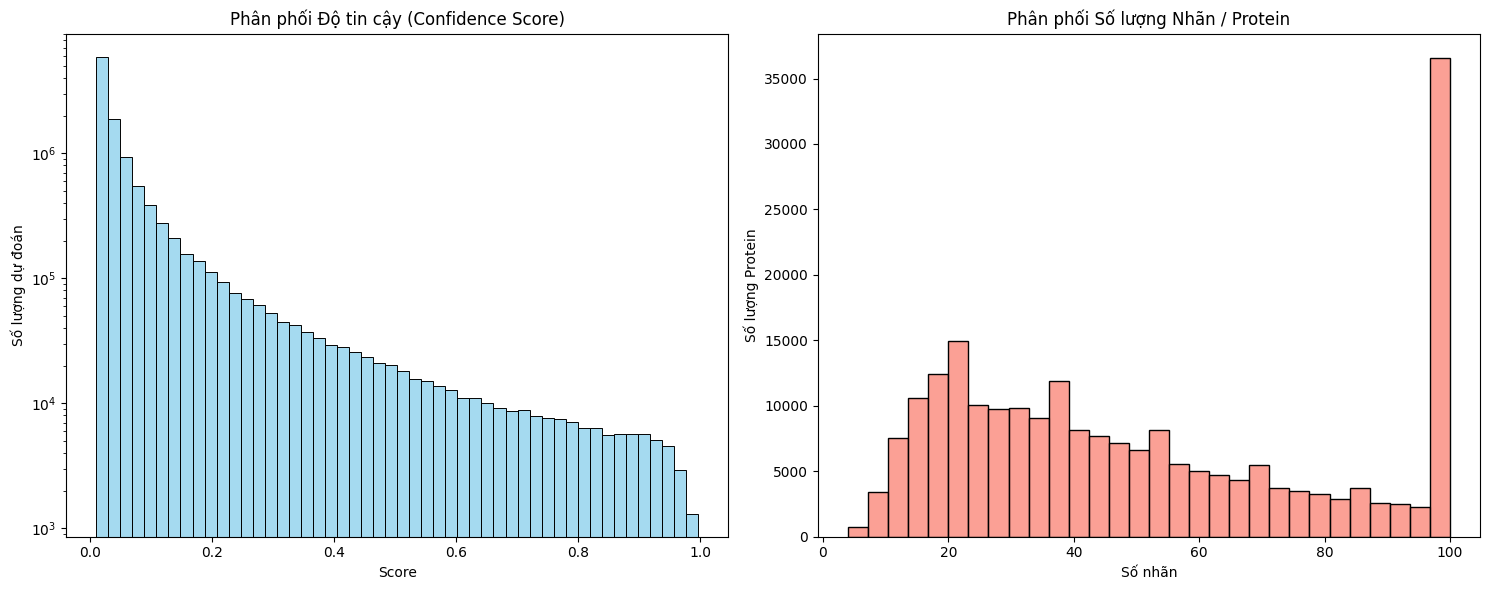


🏆 3. TOP 20 THUẬT NGỮ ĐƯỢC DỰ ĐOÁN NHIỀU NHẤT
Term
GO:0005515    224004
GO:0005829    219612
GO:0042802    198696
GO:0005634    190897
GO:0005737    173165
GO:0016020    168317
GO:0005739    167899
GO:0005576    120479
GO:0032991    111353
GO:0005783    102341
GO:0048471     96450
GO:0005794     92615
GO:0044877     85194
GO:0005654     71227
GO:0009536     69787
GO:0005730     68844
GO:0009410     68702
GO:0019904     67913
GO:0009986     60836
GO:0019899     60511
Name: count, dtype: int64

Tổng số Protein trong file: 224,309
⚠️ CẢNH BÁO: Term GO:0005515 xuất hiện ở 99.9% proteins (Quá phổ biến!)
⚠️ CẢNH BÁO: Term GO:0005829 xuất hiện ở 97.9% proteins (Quá phổ biến!)
⚠️ CẢNH BÁO: Term GO:0042802 xuất hiện ở 88.6% proteins (Quá phổ biến!)
⚠️ CẢNH BÁO: Term GO:0005634 xuất hiện ở 85.1% proteins (Quá phổ biến!)
⚠️ CẢNH BÁO: Term GO:0005737 xuất hiện ở 77.2% proteins (Quá phổ biến!)
⚠️ CẢNH BÁO: Term GO:0016020 xuất hiện ở 75.0% proteins (Quá phổ biến!)
⚠️ CẢNH BÁO: Term GO:0005739 xuất

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ================= CONFIG =================
# Thay đường dẫn file bạn muốn kiểm tra vào đây
SUBMISSION_PATH = '/content/drive/MyDrive/CAFA6_Results/Ankh_Base_Run/submission.tsv'
# ==========================================

print(f"📂 Đang đọc file: {SUBMISSION_PATH} ...")
df = pd.read_csv(SUBMISSION_PATH, sep='\t', header=None, names=['ProteinID', 'Term', 'Score'])

print(f"✅ Đã tải xong. Tổng số dòng dự đoán: {len(df):,}")

# ================= 1. THỐNG KÊ CƠ BẢN =================
print("\n" + "="*40)
print("📊 1. THỐNG KÊ ĐIỂM SỐ (CONFIDENCE SCORE)")
print("="*40)
print(df['Score'].describe().apply(lambda x: format(x, 'f')))

# ================= 2. THỐNG KÊ SỐ NHÃN / PROTEIN =================
print("\n" + "="*40)
print("📊 2. SỐ LƯỢNG NHÃN TRÊN MỖI PROTEIN")
print("="*40)
preds_per_protein = df.groupby('ProteinID').size()
print(preds_per_protein.describe())

# ================= 3. VẼ BIỂU ĐỒ PHÂN PHỐI =================
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Biểu đồ 1: Phân phối điểm số
sns.histplot(df['Score'], bins=50, kde=False, color='skyblue', ax=axes[0])
axes[0].set_title('Phân phối Độ tin cậy (Confidence Score)')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Số lượng dự đoán')
axes[0].set_yscale('log') # Dùng thang log vì số lượng score thấp thường rất lớn

# Biểu đồ 2: Phân phối số lượng nhãn mỗi protein
sns.histplot(preds_per_protein, bins=30, kde=False, color='salmon', ax=axes[1])
axes[1].set_title('Phân phối Số lượng Nhãn / Protein')
axes[1].set_xlabel('Số nhãn')
axes[1].set_ylabel('Số lượng Protein')

plt.tight_layout()
plt.show()

# ================= 4. KIỂM TRA TOP TERMS =================
print("\n" + "="*40)
print("🏆 3. TOP 20 THUẬT NGỮ ĐƯỢC DỰ ĐOÁN NHIỀU NHẤT")
print("="*40)
top_terms = df['Term'].value_counts().head(20)
print(top_terms)

# Kiểm tra xem có thuật ngữ nào chiếm quá 50% số protein không
n_proteins = df['ProteinID'].nunique()
print(f"\nTổng số Protein trong file: {n_proteins:,}")
for term, count in top_terms.items():
    percent = (count / n_proteins) * 100
    if percent > 50:
        print(f"⚠️ CẢNH BÁO: Term {term} xuất hiện ở {percent:.1f}% proteins (Quá phổ biến!)")

📂 Đang đọc file: /content/drive/MyDrive/CAFA6_Results/ESM2_Run/submission.tsv ...
✅ Đã tải xong. Tổng số dòng dự đoán: 4,404,027

📊 1. THỐNG KÊ ĐIỂM SỐ (CONFIDENCE SCORE)
count    4404027.000000
mean           0.134202
std            0.157041
min            0.010000
25%            0.038000
50%            0.075000
75%            0.161000
max            0.997000
Name: Score, dtype: object

📊 2. SỐ LƯỢNG NHÃN TRÊN MỖI PROTEIN
count    224309.000000
mean         19.633751
std           1.523286
min           3.000000
25%          20.000000
50%          20.000000
75%          20.000000
max          20.000000
dtype: float64


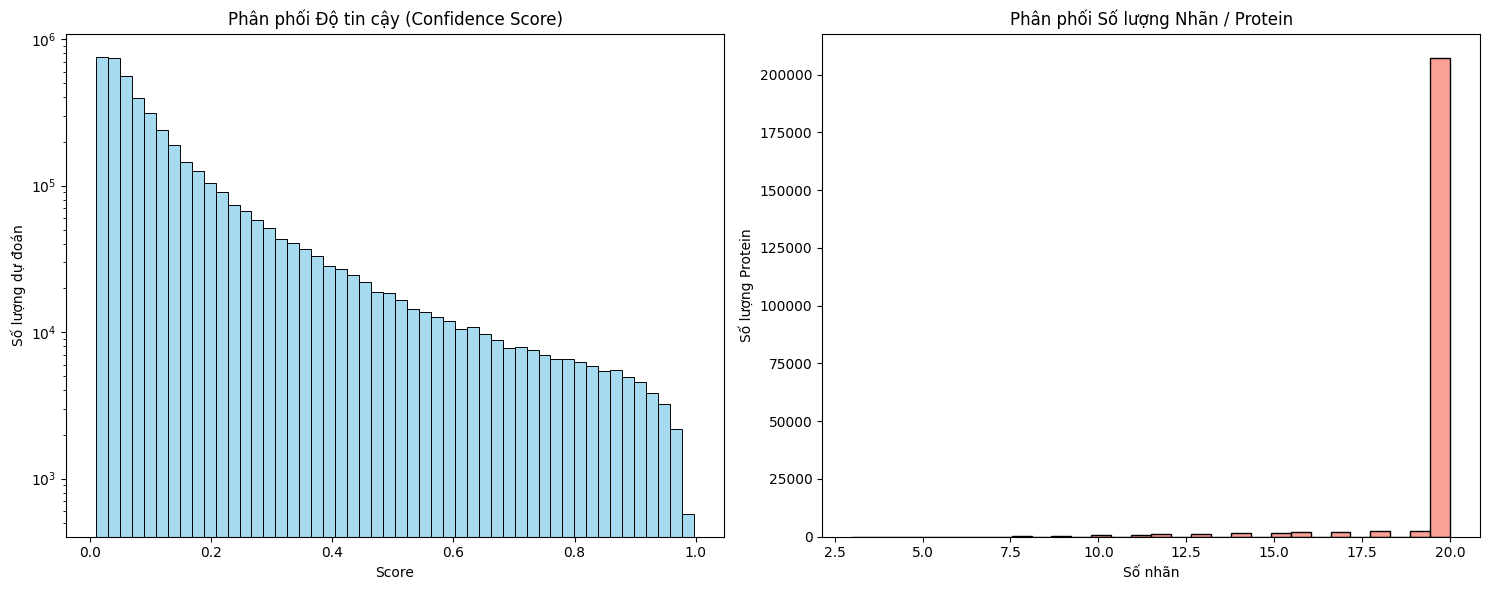


🏆 3. TOP 20 THUẬT NGỮ ĐƯỢC DỰ ĐOÁN NHIỀU NHẤT
Term
GO:0005515    188626
GO:0005829    181571
GO:0042802    160677
GO:0005634    143844
GO:0005739    109093
GO:0016020    100010
GO:0005576     84279
GO:0005737     77770
GO:0005783     50905
GO:0009536     50353
GO:0048471     43116
GO:0009986     37840
GO:0005794     37154
GO:0005615     34940
GO:0032991     32984
GO:0003682     27881
GO:0005730     27488
GO:0005654     27458
GO:0003729     27369
GO:0003723     23846
Name: count, dtype: int64

Tổng số Protein trong file: 224,309
⚠️ CẢNH BÁO: Term GO:0005515 xuất hiện ở 84.1% proteins (Quá phổ biến!)
⚠️ CẢNH BÁO: Term GO:0005829 xuất hiện ở 80.9% proteins (Quá phổ biến!)
⚠️ CẢNH BÁO: Term GO:0042802 xuất hiện ở 71.6% proteins (Quá phổ biến!)
⚠️ CẢNH BÁO: Term GO:0005634 xuất hiện ở 64.1% proteins (Quá phổ biến!)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ================= CONFIG =================
# Thay đường dẫn file bạn muốn kiểm tra vào đây
SUBMISSION_PATH = '/content/drive/MyDrive/CAFA6_Results/ESM2_Run/submission.tsv'
# ==========================================

print(f"📂 Đang đọc file: {SUBMISSION_PATH} ...")
df = pd.read_csv(SUBMISSION_PATH, sep='\t', header=None, names=['ProteinID', 'Term', 'Score'])

print(f"✅ Đã tải xong. Tổng số dòng dự đoán: {len(df):,}")

# ================= 1. THỐNG KÊ CƠ BẢN =================
print("\n" + "="*40)
print("📊 1. THỐNG KÊ ĐIỂM SỐ (CONFIDENCE SCORE)")
print("="*40)
print(df['Score'].describe().apply(lambda x: format(x, 'f')))

# ================= 2. THỐNG KÊ SỐ NHÃN / PROTEIN =================
print("\n" + "="*40)
print("📊 2. SỐ LƯỢNG NHÃN TRÊN MỖI PROTEIN")
print("="*40)
preds_per_protein = df.groupby('ProteinID').size()
print(preds_per_protein.describe())

# ================= 3. VẼ BIỂU ĐỒ PHÂN PHỐI =================
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Biểu đồ 1: Phân phối điểm số
sns.histplot(df['Score'], bins=50, kde=False, color='skyblue', ax=axes[0])
axes[0].set_title('Phân phối Độ tin cậy (Confidence Score)')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Số lượng dự đoán')
axes[0].set_yscale('log') # Dùng thang log vì số lượng score thấp thường rất lớn

# Biểu đồ 2: Phân phối số lượng nhãn mỗi protein
sns.histplot(preds_per_protein, bins=30, kde=False, color='salmon', ax=axes[1])
axes[1].set_title('Phân phối Số lượng Nhãn / Protein')
axes[1].set_xlabel('Số nhãn')
axes[1].set_ylabel('Số lượng Protein')

plt.tight_layout()
plt.show()

# ================= 4. KIỂM TRA TOP TERMS =================
print("\n" + "="*40)
print("🏆 3. TOP 20 THUẬT NGỮ ĐƯỢC DỰ ĐOÁN NHIỀU NHẤT")
print("="*40)
top_terms = df['Term'].value_counts().head(20)
print(top_terms)

# Kiểm tra xem có thuật ngữ nào chiếm quá 50% số protein không
n_proteins = df['ProteinID'].nunique()
print(f"\nTổng số Protein trong file: {n_proteins:,}")
for term, count in top_terms.items():
    percent = (count / n_proteins) * 100
    if percent > 50:
        print(f"⚠️ CẢNH BÁO: Term {term} xuất hiện ở {percent:.1f}% proteins (Quá phổ biến!)")